# Reconstruction of DOSY NMR signals - Part I
## Authors : Simon Queric - Valerio Guerrini - Vincent Herfeld

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Question 1:

Text(0, 0.5, 'x(n)')

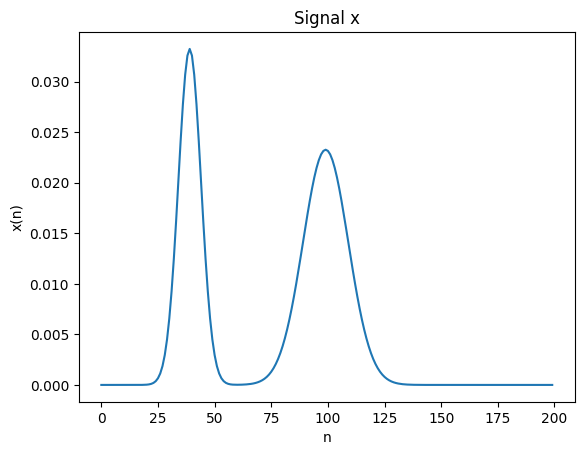

In [3]:
x = np.loadtxt("./x.txt")
plt.plot(x)
plt.title("Signal x")
plt.xlabel("n")
plt.ylabel("x(n)")

### Question 2 :

Text(0, 0.5, 'T(n)')

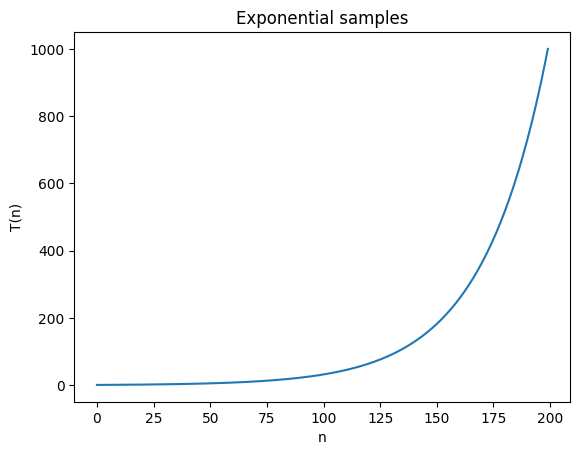

In [4]:
Tmin = 1
Tmax = 1000
T = []
N  = len(x)

T = Tmin * np.exp(-(np.arange(1, N+1) - 1) * np.log(Tmin / Tmax)/(N - 1))
    
plt.plot(T)
plt.title("Exponential samples")
plt.xlabel("n")
plt.ylabel("T(n)")

### Question 3:

Text(0, 0.5, 'x')

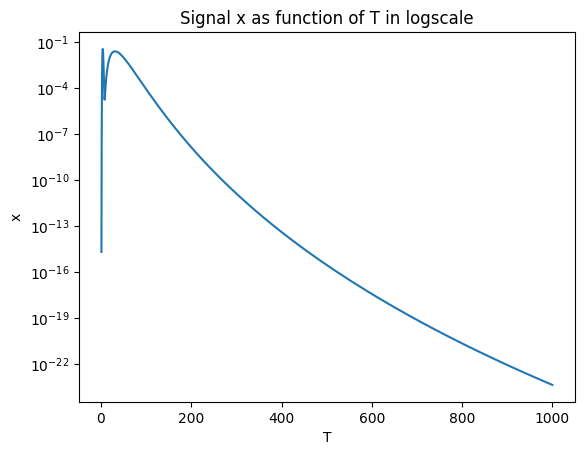

In [5]:
plt.semilogy(T, x)
plt.title("Signal x as function of T in logscale")
plt.xlabel("T")
plt.ylabel("x")

### Question 4:

Text(0, 0.5, 't(n)')

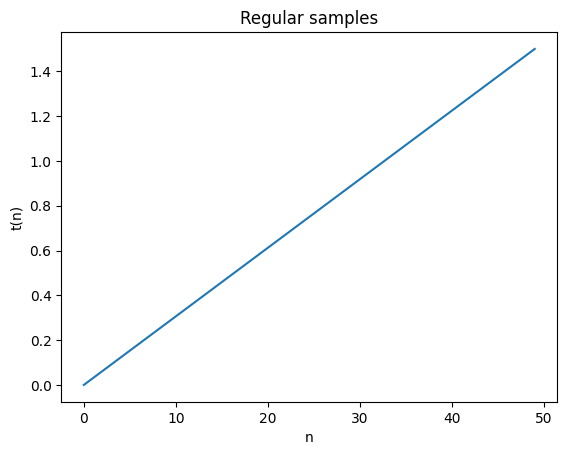

In [6]:
M = 50
tmin = 0
tmax = 1.5

t = tmin + (np.arange(1, M+1) - 1) * (tmax - tmin) / (M - 1)

plt.plot(t)
plt.title("Regular samples")
plt.xlabel("n")
plt.ylabel("t(n)")

### Question 5 : 

In [7]:
K = np.exp(-np.einsum("i, j->ij", t, T))

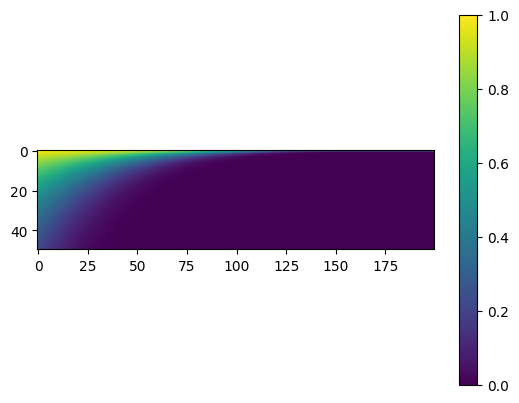

In [8]:
plt.imshow(K)
plt.colorbar()
plt.show()

### Question 6 and 7:

Text(0, 0.5, 'y(t)')

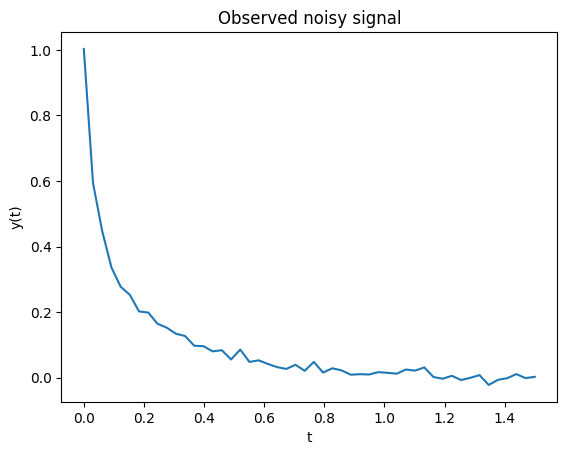

In [9]:
z = K @ x
sigma = 0.01 * z[0]
y = K @ x + np.random.multivariate_normal(np.zeros(M), (sigma**2)*np.eye(M))
plt.plot(t, y)
plt.title("Observed noisy signal")
plt.xlabel("t")
plt.ylabel("y(t)")

### Smoothness prior

The problem to solve is the following :

\begin{equation}
    \underset{x\in \mathbb{R}^N}{\text{argmin}}{\frac{1}{2}\|Kx -y\|^2 + \frac{\beta}{2} \|Dx\|^2}
\end{equation}

which has a closed form solution : 

\begin{equation}
    \widehat{x} = (K^TK + \beta D^TD)^{-1}K^Ty
\end{equation}

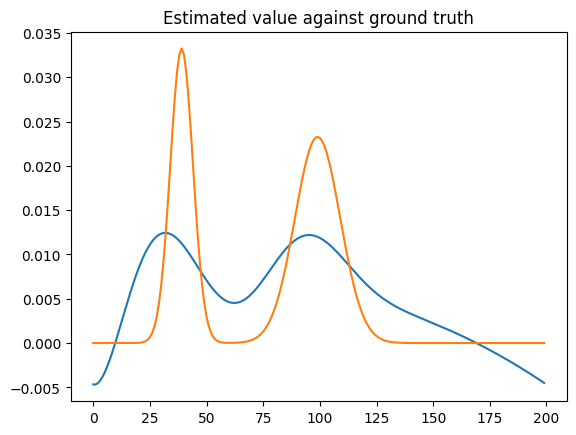

The quadratic error of the estimation is : 0.40151940815696324


In [10]:
D = np.eye(N)
D[1:N, :N-1] -= np.eye(N-1)
D[0,N-1] = -1

beta = 10

x_est_smooth = np.linalg.pinv(K.T @ K + beta * D.T @ D) @ K.T @ y

plt.title("Estimated value against ground truth")
plt.plot(x_est_smooth)
plt.plot(x)
plt.show()

print(f"The quadratic error of the estimation is : {(np.linalg.norm(x_est_smooth-x)/np.linalg.norm(x))**2}")

### Smoothness prior with constraints

The problem to solve is the following :

\begin{equation}
    \underset{x\in \mathbb{R}^N}{\text{argmin}}{\frac{1}{2}\|Kx -y\|^2 + \frac{\beta}{2} \|Dx\|^2 + \iota_{[x_{\text{min}}, x_{\text{max}}]^N}}(x)
\end{equation}

We therefore use the projected gradient descent.

In [11]:
def projection(x, x_min, x_max) :
    z = np.zeros_like(x)
    for i in range(len(z)):
        z[i] = x[i]*(x_min<=x[i])*(x[i]<=x_max) + x_min*(x[i]<x_min) + x_max*(x[i]>x_max)

    return z

In [12]:
def projected_gradient(y, K, x_min, x_max, beta, Lambda=1, stepsize=1e-2, n_iter=100) :
    x = (x_max+x_min)/2 * np.ones(N)
    for n in range(1, n_iter) :
        z = x-stepsize*((K.T@K+beta*D.T@D)@x - K.T@y)
        x = x + Lambda/n*(projection(z, x_min, x_max) - x)
    return x

In [13]:
x_est_smoothconstr = projected_gradient(y, K, x_min=np.min(x), x_max=np.max(x), beta=15, stepsize=1, n_iter=1000)

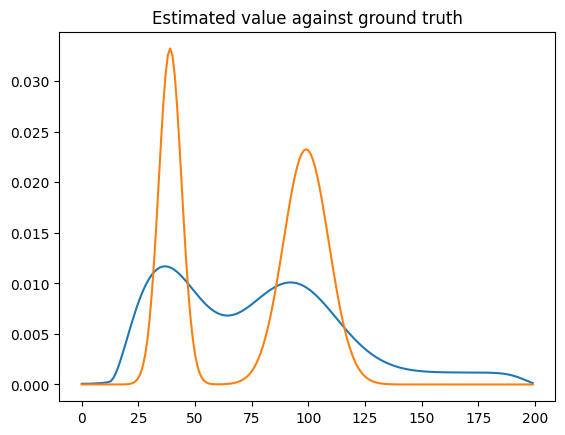

The quadratic error of the estimation is : 0.40642080892325017


In [14]:

plt.title("Estimated value against ground truth")
plt.plot(x_est_smoothconstr)
plt.plot(x)
plt.show()

print(f"The quadratic error of the estimation is : {(np.linalg.norm(x_est_smoothconstr-x)/np.linalg.norm(x))**2}")

### Sparsity prior

The problem to solve is the following :

\begin{equation}
    \underset{x\in \mathbb{R}^N}{\text{argmin}}{\frac{1}{2}\|Kx -y\|^2 + \beta \|x\|_1}
\end{equation}

We can use the forward-backward algorithm.

In [15]:
def proximal_l1(x, gamma):
    return np.sign(x)*np.maximum(0, np.abs(x)-gamma)

In [40]:
def proximal_gradient_descent(y, K, Lambda=1, beta=5, stepsize=1, n_iter=1000):
    x = 1e-4*np.ones(N)
    for n in range(1, n_iter) :
        z = x- stepsize*K.T@(K@x - y)
        x = x + Lambda/n * (proximal_l1(z, beta*stepsize) - x)
    return x

In [41]:
x_est_spars = proximal_gradient_descent(y, K, Lambda=1, beta=0.1, stepsize=1e-1, n_iter=100)

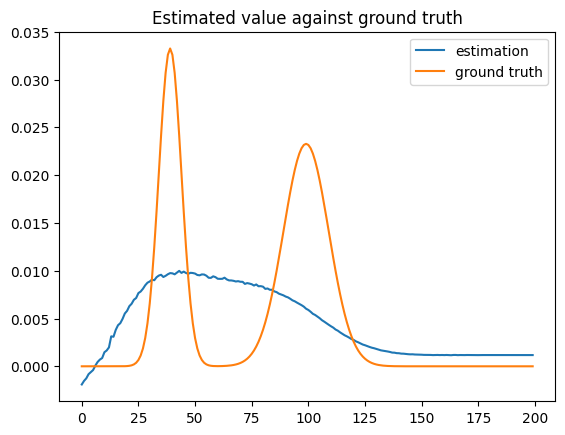

The quadratic error of the estimation is : 0.573831951348068


In [42]:

plt.title("Estimated value against ground truth")
plt.plot(x_est_spars, label="estimation")
plt.plot(x, label="ground truth")
plt.legend()
plt.show()

print(f"The quadratic error of the estimation is : {(np.linalg.norm(x_est_spars-x)/np.linalg.norm(x))**2}")

# Reconstruction of DOSY NMR signals - Part II

## Maximum entropy regularization

The maximum entropy problem writes :

$$
\begin{align*}
\hat{x} = \underset{x\in\mathbb{R}^N}{\text{argmin}} \frac{1}{2}||Kx−y||^2+\beta \text{ent}(x),
\end{align*}
$$

### Question 1:


\begin{align*}
\forall x \in \mathbb{R}^N, \; \text{ent}(x) = \sum_{n = 1}^{N} \varphi(x^{(n)}) = \sum_{n = 1}^{N} \varphi_n(x)
\end{align*}


where $ent$ is seperable : $\varphi_n : x \mapsto \varphi(x^{(n)})$ and 

\begin{equation}\varphi : u \mapsto 
    \begin{cases}
      u\log(u) \;\text{if $u > 0$}\\
      0   \;\; \;\;\;\; \;\,  \;\;\text{if $u = 0$}\\
      +\infty \;\;\;\;\;\;\text{otherwise}
    \end{cases}\,
\end{equation}

On $]0, +\infty[ \varphi'(u) = \log u + 1$ and $\varphi''(u) = \frac{1}{u} > 0$, so $\varphi$ is strictly convex on $]0, +\infty[$ and since ent is the sum of convex functions it is also convex. $\varphi$ is continuous over $[0, +\infty[$ and thus is lower-semi-continuous on $\mathbb{R}$, some thing for differentiablity as long as $u > 0$,  $\varphi$ is differentiable but not on all of $\mathbb{R}$ so ent is $l.s.c$ and non-differentiable on $\mathbb{R}^N$ by sum. It is also proper since it has a non empty domain.

### Question 2:

The problem is coercive proper and l.s.c. so a minimizer exists and it is unique since ent is strictly convex and $g : x \mapsto \frac{1}{2}||Kx−y||^2$ is also strictly convexe. Indeed :


$$
\begin{align*}
g(x + h) &= \frac{1}{2} \langle Kx + Kh - y, Kx + Kh - y \rangle = g(x)\; + \langle h, K^T(Kx - y)\rangle +\; o(h) \Rightarrow dg_x(h) = \langle h, K^T(Kx - y) \rangle \\
\text{and so,}\\
dg_{x+u}(h) &= \langle h, K^T(Kx + Ku - y) \rangle = dg_x(h) + \langle h, K^TKu \rangle + o(u) \Rightarrow \text{Hess}(g)(x) = K^TK \;\text{is SPD, so $g$ is strictly convex}.
\end{align*}
$$.

By sum the problem is strictly convex so the minimizer is unique.

### Question 3:

$prox_{\beta\text{ent}}(x) = \underset{y \in \mathbb{R}^N}{\text{argmin}} \; \beta \text{ent}(y) + \frac{1}{2}||x - y||^2 $ looking at the definition of ent we know that the solution to the previous has to be in $\mathbb{R}_+^N$.

$f(y) = \beta \text{ent}(y) + \frac{1}{2}||x - y||^2 = \sum_{n=1}^{N} y^{(n)}\log y^{(n)} + \frac{1}{2}||x - y||^2$ is strictly convex. Looking at the partial derivatives we have : 

$$
\begin{align*}
\frac{\partial f}{\partial y^{(n)}}(y) = \beta \log y^{(n)} + \beta + y^{(n)} - x^{(n)}
\end{align*}
$$

we want to cancel these out : 

$$
\begin{align*}
\frac{\partial f}{\partial y^{(n)}}(y) = 0 &\Leftrightarrow \log y^{(n)} + \frac{1}{\beta}y^{(n)} = \frac{1}{\beta} x^{(n)} - 1\\
&\Leftrightarrow \beta \left(\frac{1}{\beta}y^{(n)}\exp\left(\frac{1}{\beta}y^{(n)}\right)\right)= \exp\left(\frac{1}{\beta} x^{(n)} - 1\right)\\
&\Leftrightarrow  \frac{1}{\beta}y^{(n)} = W_0\left(\frac{1}{\beta}\exp\left(\frac{1}{\beta} x^{(n)} - 1\right)\right)\\
&\Leftrightarrow  y^{(n)} = \beta W_0\left(\frac{1}{\beta}\exp\left(\frac{1}{\beta} x^{(n)} - 1\right)\right)\\
\text{and so finally we have, }\\
prox_{\beta\text{ent}}(x) &= \left(\beta W_0\left(\frac{1}{\beta}\exp\left(\frac{1}{\beta} x^{(n)} - 1\right)\right)\right)_{n=1}^{N}
\end{align*}.
$$
where $W_0$ is the W-Lambert function and since we are in $\mathbb{R}^N$ we will take the real part.


### Question 4:

For the following algorithms we also need the proximal operator of the function $g(x) = \frac{1}{2}||Kx - y||^2$ which is given by canceling out the gradient of $u \mapsto \frac{1}{2}||Ku - y||^2 + \frac{1}{2}||x - u||^2$ and that is exactly : $\text{prox}_g(x) = (K^TK + I_N)^{-1}(K^Ty - x)$ .

In [48]:
from scipy.special import lambertw

In [49]:
def prox_f(x):
    return np.linalg.pinv(K.T @ K + np.eye(N)) @ (K.T @ y + x)

def prox_h(x, gamma = 1):
    return gamma * np.real(lambertw(np.exp(x / gamma - 1) / gamma))


def ent(x):
    u = np.empty_like(x)
    for i,xi in enumerate(x):
        if xi < 0:
            return np.inf
        elif xi == 0:
            u[i] = 0
        else:
            u[i] = xi*np.log(xi)
    return u.sum()

def grad_f(x):
    return K.T @ (K @ x - y)

def obj(x, beta):
    return 0.5*np.linalg.norm(K@x - y)**2 + ent(x) * beta

In [88]:
def Forward_Backward(x0, beta, N_iter, seq):
    x = x0.copy()
    val = [obj(x,beta[0])]
    for i in range(N_iter):
        u = x - beta[i]*grad_f(x)
        x = x + seq[i]*(prox_h(u, beta[i]) - x)
        val.append(obj(x, beta[i]))
    return x, val

def DR(x0, beta, N_iter, seq):
    x = x0.copy()
    val = [obj(x,beta)]
    for i in range(N_iter):
        u = prox_f(x)
        z = prox_h(2*u - x, beta)
        x = x + seq[i] * (z - u)
        val.append(obj(x, beta))
    return x, val

### Question 5:

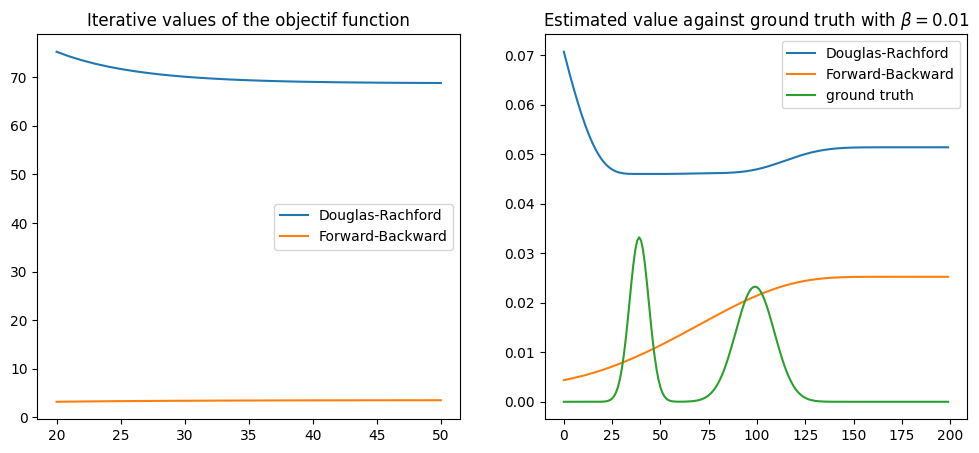

The quadratic errors of the estimation are for DR: 21.80799680285372 and for FB:3.3299480071037935
The relative errors of the estimation are for DR: 4.669903296948847 and for FB:1.8248145130680524


In [94]:
N_iter_DR = 50
N_iter_FB = 50

lam_DR = 1*np.ones(N_iter_DR)
lam_FB = 0.1*np.ones(N_iter_FB)

beta_DR = 1e-2
beta_FB = 1e-2*np.ones(N_iter_FB)

x_est_DR,val_DR  = DR(x0 = 0.1*np.ones(N), beta = beta_DR, N_iter = N_iter_DR, seq = lam_DR)
x_est_FB, val_FB = Forward_Backward(x0 = 0.01*np.ones(N), beta = beta_FB, N_iter = N_iter_FB, seq = lam_FB)

zoom = 20

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 5))

ax1.set_title("Iterative values of the objectif function")
ax1.plot(np.arange(N_iter_DR + 1)[zoom:], val_DR[zoom:], label="Douglas-Rachford")
ax1.plot(np.arange(N_iter_FB + 1)[zoom:], val_FB[zoom:], label="Forward-Backward")
ax2.set_title(r"Estimated value against ground truth with $\beta = {}$".format(beta_DR))
ax2.plot(x_est_DR, label="Douglas-Rachford")
ax2.plot(x_est_FB, label="Forward-Backward")
ax2.plot(x, label ="ground truth")
ax1.legend()
ax2.legend()
plt.show()

print(f"The quadratic errors of the estimation are for DR: {np.linalg.norm(x_est_DR - x)**2/np.linalg.norm(x)**2 } and for FB:{np.linalg.norm(x_est_FB - x)**2/np.linalg.norm(x)**2}")
print(f"The relative errors of the estimation are for DR: {np.linalg.norm(x_est_DR - x) / np.linalg.norm(x)} and for FB:{np.linalg.norm(x_est_FB - x) / np.linalg.norm(x)}")


### Question 6:

By tweeking around the parameters we find good estimation through Douglass-Rachford, for Forward-Backwards it is not the same story.

In [95]:
beta_DR = 0.4* 1e-3
beta_FB = np.ones(N_iter_FB) / np.linspace(1, 1000, N_iter_FB) #varying step_size


x_est_DR,val_DR = DR(x0 = 0.1*np.ones(N), beta = beta_DR, N_iter = N_iter_DR, seq = lam_DR)
x_est_FB, val_FB = Forward_Backward(x0 = 0.01*np.ones(N), beta = beta_FB, N_iter = N_iter_FB, seq = lam_FB)


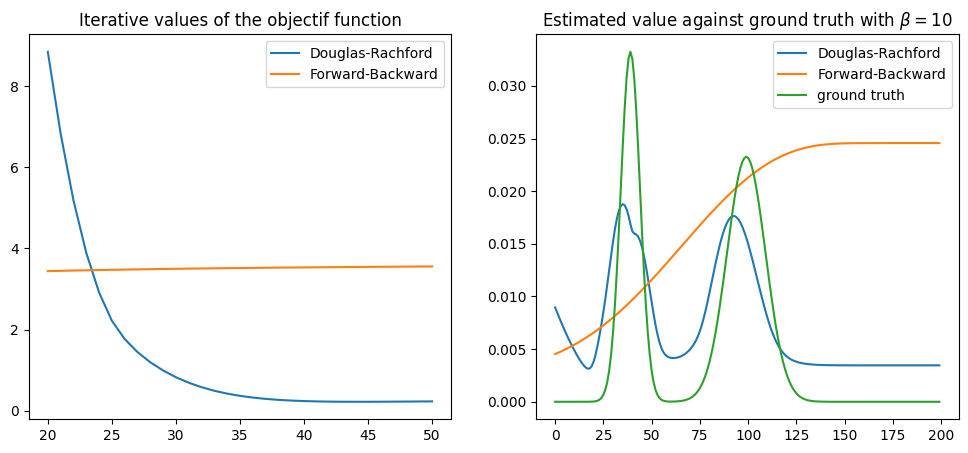

The quadratic errors of the estimation are for DR: 0.29834972178484553 and for FB:3.1960091311572985
The relative errors of the estimation are for DR: 0.5462139890050836 and for FB:1.787738552237798


In [96]:
zoom = 20

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 5))

ax1.set_title("Iterative values of the objectif function")
ax1.plot(np.arange(N_iter_DR + 1)[zoom:], val_DR[zoom:], label="Douglas-Rachford")
ax1.plot(np.arange(N_iter_FB + 1)[zoom:], val_FB[zoom:], label="Forward-Backward")
ax2.set_title(r"Estimated value against ground truth with $\beta = {}$".format(beta))
ax2.plot(x_est_DR, label="Douglas-Rachford")
ax2.plot(x_est_FB, label="Forward-Backward")
ax2.plot(x, label ="ground truth")
ax1.legend()
ax2.legend()
plt.show()

print(f"The quadratic errors of the estimation are for DR: {np.linalg.norm(x_est_DR - x)**2/np.linalg.norm(x)**2 } and for FB:{np.linalg.norm(x_est_FB - x)**2/np.linalg.norm(x)**2}")
print(f"The relative errors of the estimation are for DR: {np.linalg.norm(x_est_DR - x) / np.linalg.norm(x)} and for FB:{np.linalg.norm(x_est_FB - x) / np.linalg.norm(x)}")


### Question 7:

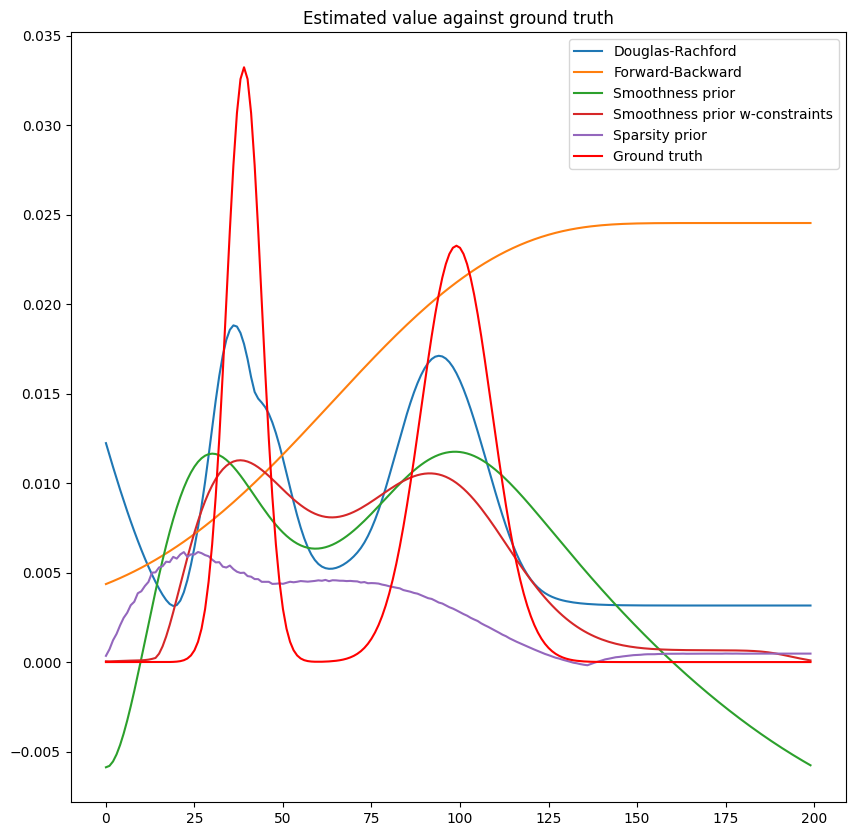

In [56]:
zoom = 20

fig = plt.figure(figsize=(10,10))
plt.title(r"Estimated value against ground truth".format(beta))
plt.plot(x_est_DR, label="Douglas-Rachford")
plt.plot(x_est_FB, label="Forward-Backward")
plt.plot(x_est_smooth, label="Smoothness prior")
plt.plot(x_est_smoothconstr, label="Smoothness prior w-constraints")
plt.plot(x_est_spars, label="Sparsity prior")
plt.plot(x, label ="Ground truth", color="red")
plt.legend()
plt.show()

In [59]:
import pandas as pd

In [65]:
Names = ["Douglass-Rachford", "Forward-Back", "Smoothness prior", "Smoothness prior w constraints", "Sparsity prior"]
X_est = [x_est_DR, x_est_FB, x_est_smooth, x_est_smoothconstr, x_est_spars]
d = {"estimator": [],"quadratic error":[], "relative error": []}

for x_est, name in zip(X_est, Names):
    d["estimator"].append(name)
    d["quadratic error"].append(np.linalg.norm(x_est - x)**2/np.linalg.norm(x)**2)
    d["relative error"].append(np.linalg.norm(x_est - x)/np.linalg.norm(x))

df = pd.DataFrame(data=d)
df

,estimator,quadratic error,relative error
0,Douglass-Rachford,0.308115,0.555081
1,Forward-Back,3.193831,1.787129
2,Smoothness prior,0.486725,0.697657
3,Smoothness prior w constraints,0.418536,0.646944
4,Sparsity prior,0.728035,0.853250


Looking at the previous table, we see that the Douglass-Rachford seems to be the best estimator whereas the Forward-Backwards would be the least efficient. The Sparsity is also not a good option for this case even though sparsity is sometimes a good prior, the smoothness priors are close to the DR method and adding constraint seems to yield better results.

### Question 8 :

Looking at the problem : $\underset{x\in\mathbb{R}^N}{\text{min}} \text{ent}(x) \;\;\text{s.t.} \;\;||Kx - y||^2 \leq \eta M \sigma^2$

We can think about implementing a projected gradient descent. The difficulty is to express clearly the projection to apply at each step.

$\nabla \text{ent}(x) = (\log(x_i) + 1)_{i=1,...,N}$

We can calculate the Lagrangian: 

$L(z, \lambda) = ||x - z||^2 + \lambda(||Kz - y||^2 - \eta M \sigma^2)$

and find the dual by minimizing the Langrangian which is convex: 

$\nabla_z L(z, \lambda) = -2(x - z) + 2\lambda K^T(Kz - y) = 0 \Leftrightarrow z = (\lambda K^TK + I_N)^{-1}(\lambda K^Ty + x)$

so the dual objective is : $g(\lambda) = ||x - (\lambda K^TK + I_N)^{-1}(\lambda K^Ty + x)||^2 + \lambda(||K(\lambda K^TK + I_N)^{-1}(\lambda K^Ty + x) - y||^2 - \eta M \sigma^2)$

In [97]:
def grad_ent(x):
    return log(x) + np.ones(N)

def proj_gradient_descent(x0, N_iter, gamma):
    x = x0.copy()
    for i in range(N_iter):
        x_temp = x - gamma[i]*grad_ent(x)
        #while np.linalg.norm(K@x_temp - y)**2 > eta*M*sigma2: #Apply projection
            #x_temp = ()
    return x



We have not found the expression for the projection.